# Investigating Customer's Demographic Information and Purchase Behaviour: A Comprehensive Offer Acceptance Analysis and Segmentation Using Machine Learning Techniques

## Importing Libraries

In [59]:
# import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats.mstats import winsorize

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.combine import SMOTETomek
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

pd.set_option('display.max_columns', 40)
warnings.filterwarnings('ignore')

## Loading Dataset

In [2]:
df = pd.read_csv('marketing_campaign.csv', delimiter='\t', quotechar='"')

In [3]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## Data Preprocessing

## Handling Missing Values

In [5]:
df['Income'].isna().sum()

24

In [6]:
df['Income'] = df.groupby('Education')['Income'].transform(lambda x: x.fillna(x.median()))

## Changing Features' Datatype

In [7]:
df['Dt_Customer'] = pd.to_datetime(df.Dt_Customer, format='%d-%m-%Y')
df['Education'] = pd.Categorical(df.Education)
df['Marital_Status'] = pd.Categorical(df.Marital_Status)

## Summary Statistics

In [8]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
ID,2240.0,5592.159821,0.0,2828.25,5458.5,8427.75,11191.0,3246.662198
Year_Birth,2240.0,1968.805804,1893.0,1959.0,1970.0,1977.0,1996.0,11.984069
Income,2240.0,52242.594866,1730.0,35538.75,51498.5,68289.75,666666.0,25039.061738
Kidhome,2240.0,0.444196,0.0,0.0,0.0,1.0,2.0,0.538398
Teenhome,2240.0,0.50625,0.0,0.0,0.0,1.0,2.0,0.544538
Dt_Customer,2240,2013-07-10 10:01:42.857142784,2012-07-30 00:00:00,2013-01-16 00:00:00,2013-07-08 12:00:00,2013-12-30 06:00:00,2014-06-29 00:00:00,NaN
Recency,2240.0,49.109375,0.0,24.0,49.0,74.0,99.0,28.962453
MntWines,2240.0,303.935714,0.0,23.75,173.5,504.25,1493.0,336.597393
MntFruits,2240.0,26.302232,0.0,1.0,8.0,33.0,199.0,39.773434
MntMeatProducts,2240.0,166.95,0.0,16.0,67.0,232.0,1725.0,225.715373


In [9]:
df.describe(include='category').T

,count,unique,top,freq
Education,2240,5,Graduation,1127
Marital_Status,2240,8,Married,864


## Renaming Features Names 

In [10]:
df = df.rename(columns={'NumWebPurchases': "Web",'NumCatalogPurchases':'Catalog','NumStorePurchases':'Store', 'Dt_Customer':'Enrolled', 
                          'MntWines':'Wines', 'MntFruits':'Fruits', 'MntMeatProducts':'Meat', 'MntFishProducts':'Fish', 'MntSweetProducts':'Sweet', 
                          'MntGoldProds':'Gold', 'NumDealsPurchases':'Discount', 'NumWebVisitsMonth':'WebVisit', 'AcceptedCmp1':'Cmp1', 
                          'AcceptedCmp2':'Cmp2', 'AcceptedCmp3':'Cmp3', 'AcceptedCmp4':'Cmp4', 'AcceptedCmp5':'Cmp5', 'Kidhome': 'Kid', 
                          'Year_Birth':'Year', 'Marital_Status':'Status', 'Teenhome':'Teen'})

## Exploratory Data Analysis

### Univariate Analysis

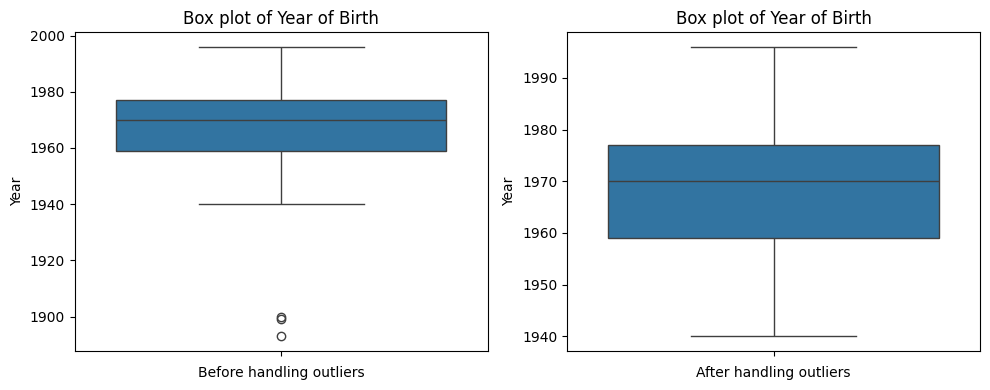

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))
sns.boxplot(df.Year, ax=axes[0])
axes[0].set_title('Box plot of Year of Birth')
axes[0].set_xlabel('Before handling outliers')
df['Year'] = winsorize(df['Year'], limits = (0.0015, 0))
sns.boxplot(df.Year, ax=axes[1])
axes[1].set_title('Box plot of Year of Birth')
axes[1].set_xlabel('After handling outliers')
plt.tight_layout()
plt.show()

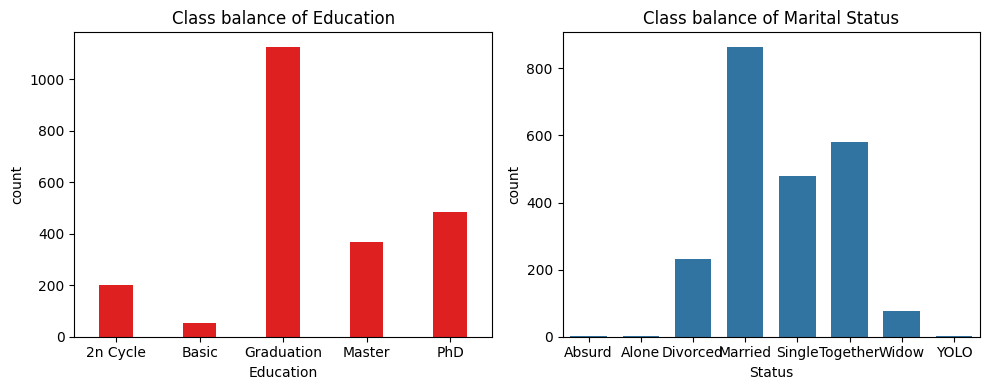

In [12]:
# Class balance of Education and Marital Status
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x=df.Education, width=0.4, color='red', ax=axes[0])
axes[0].set_title('Class balance of Education')
sns.countplot(x=df.Status, width=0.7, ax=axes[1])
axes[1].set_title('Class balance of Marital Status')
plt.tight_layout()
plt.show()

In [13]:
df['Status'] = df['Status'].replace({ 'Divorced':'Divorce_Widow', 'Widow':'Divorce_Widow', 'Alone':'Single', 'Absurd':'Single', 'YOLO':'Single'})
df['Education'] = df['Education'].replace({'Basic':'Below_UG','2n Cycle':'Below_UG', 'Master':'PG', 'Graduation':'UG'})

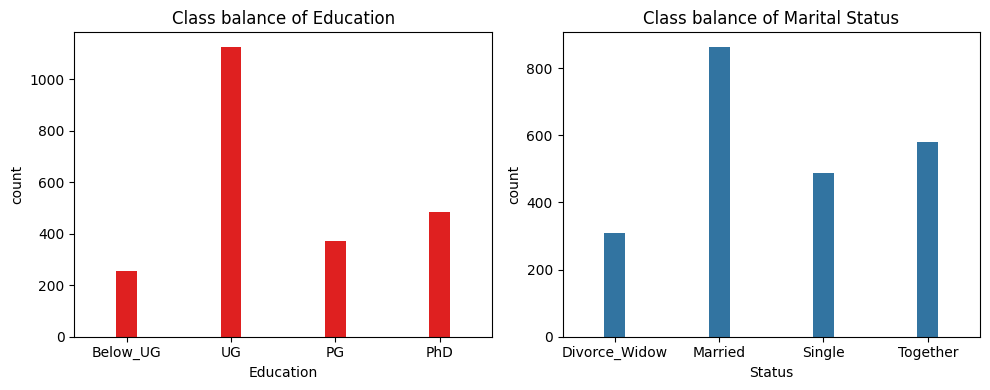

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x=df.Education, width=0.2, color='red', ax=axes[0])
axes[0].set_title('Class balance of Education')
sns.countplot(x=df.Status, width=0.2, ax=axes[1])
axes[1].set_title('Class balance of Marital Status')
plt.tight_layout()
plt.show()

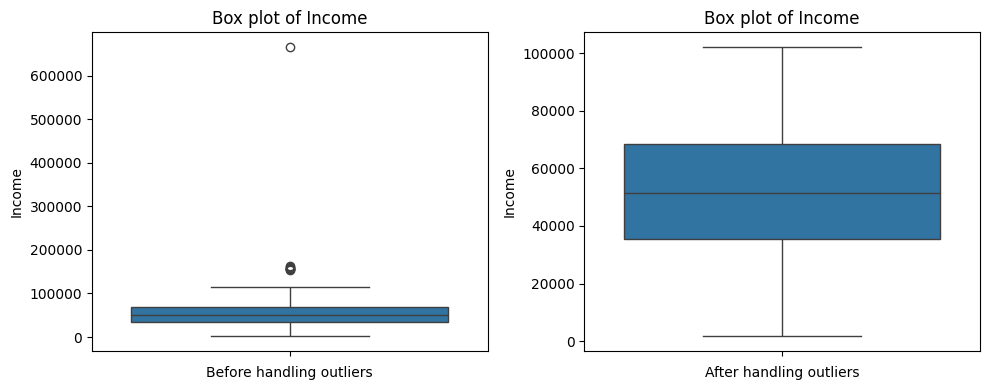

In [15]:
# Distribution of Income
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(df.Income, ax=axes[0])
axes[0].set_title('Box plot of Income')
axes[0].set_xlabel('Before handling outliers')
df['Income'] = winsorize(df['Income'], limits=(0, 0.005))
sns.boxplot(df.Income, ax=axes[1])
axes[1].set_title('Box plot of Income')
axes[1].set_xlabel('After handling outliers')
plt.tight_layout()
plt.show()

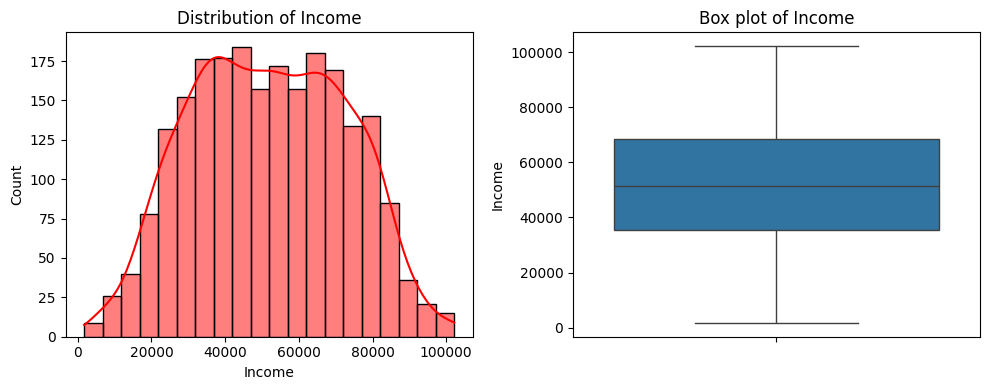

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df.Income, bins=20, kde=True, color='red', ax=axes[0])
axes[0].set_title('Distribution of Income')
sns.boxplot(df.Income, ax=axes[1])
axes[1].set_title('Box plot of Income')
plt.tight_layout()
plt.show()

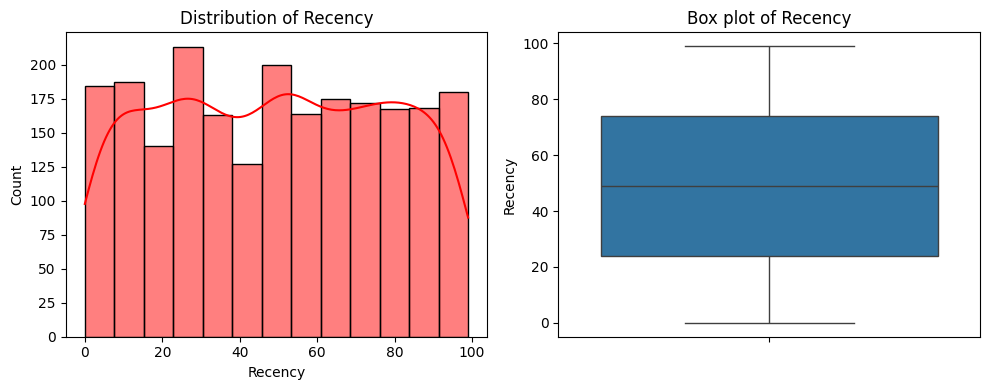

In [17]:
# Distribution of Recency
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df.Recency, kde=True, color='red', ax=axes[0])
axes[0].set_title('Distribution of Recency')
sns.boxplot(df.Recency, ax=axes[1])
axes[1].set_title('Box plot of Recency')
plt.tight_layout()
plt.show()

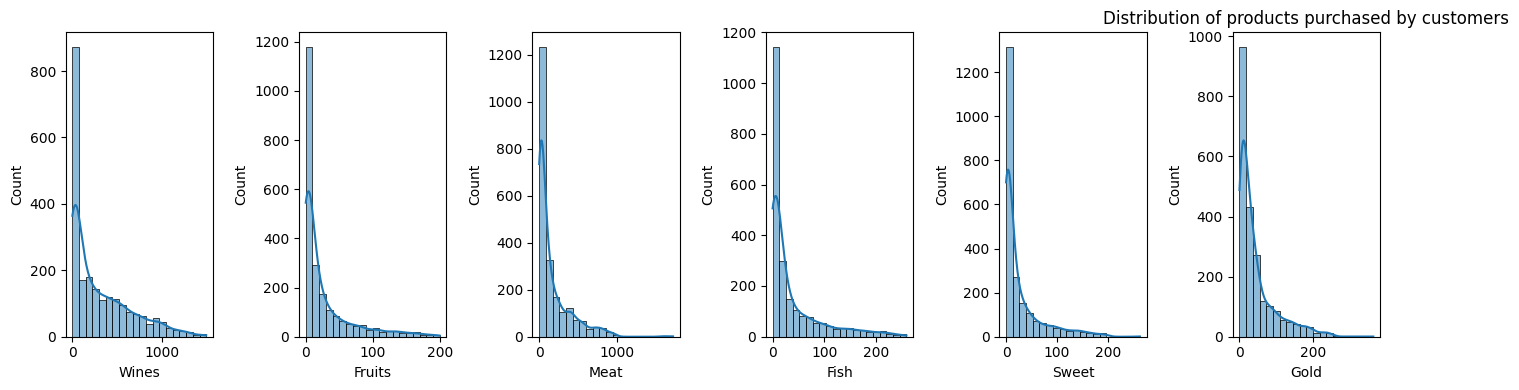

In [18]:
fig, axes = plt.subplots(1, 6, figsize=(14, 4))
plt.title('Distribution of products purchased by customers')
sns.histplot(df.Wines, bins=20, kde=True, ax=axes[0])
sns.histplot(df.Fruits, bins=20, kde=True, ax=axes[1])
sns.histplot(df.Meat, bins=20, kde=True, ax=axes[2])
sns.histplot(df.Fish, bins=20, kde=True, ax=axes[3])
sns.histplot(df.Sweet, bins=20, kde=True, ax=axes[4])
sns.histplot(df.Gold, bins=20, kde=True, ax=axes[5])
plt.tight_layout()
plt.show()

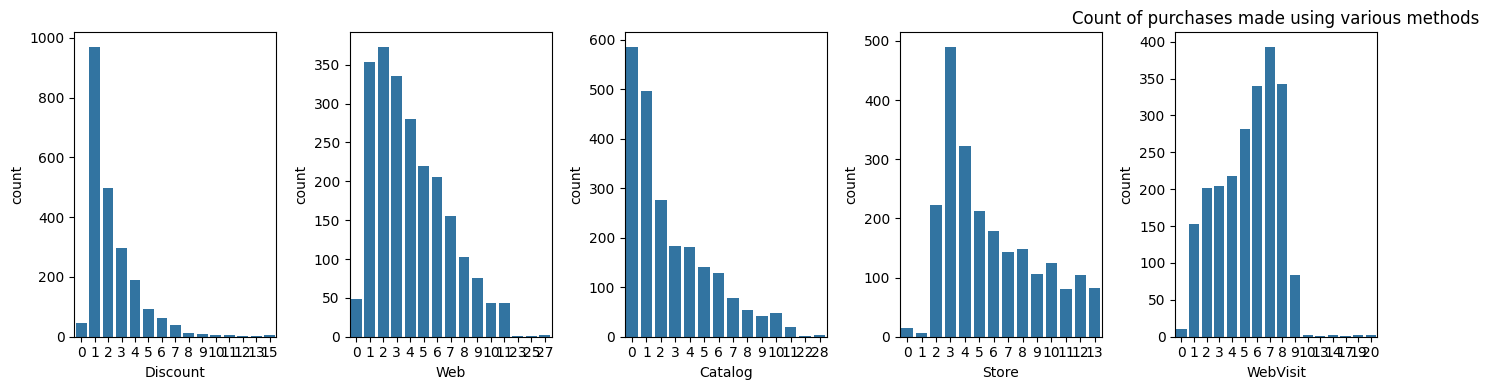

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(14, 4))
plt.title('Count of purchases made using various methods')
sns.countplot(x=df.Discount, ax=axes[0])
sns.countplot(x=df.Web, ax=axes[1])
sns.countplot(x=df.Catalog, ax=axes[2])
sns.countplot(x=df.Store, ax=axes[3])
sns.countplot(x=df.WebVisit, ax=axes[4])
plt.tight_layout()
plt.show()

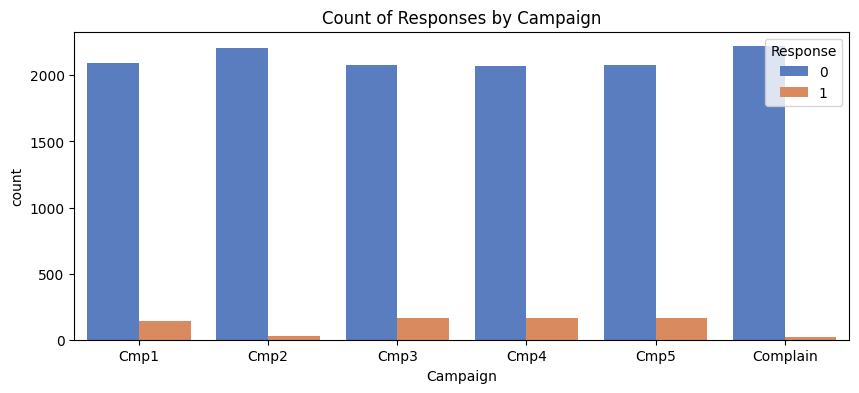

In [20]:
df_melted = df[['Cmp1', 'Cmp2', 'Cmp3', 'Cmp4', 'Cmp5', 'Complain']].melt(var_name='Campaign', value_name='Response')
plt.figure(figsize=(10, 4))
sns.countplot(x='Campaign', hue='Response', data=df_melted, palette='muted')
plt.title('Count of Responses by Campaign')
plt.show()

### Bivariate Analysis

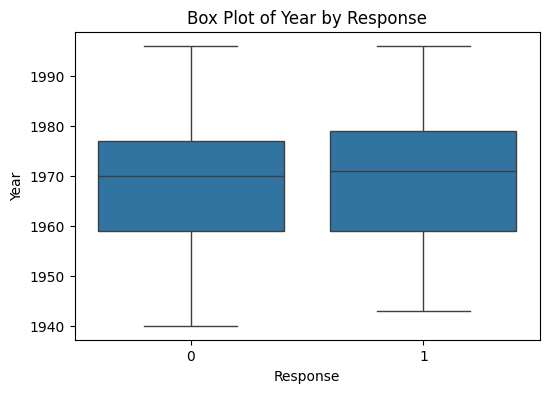

In [21]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df.Response, y=df.Year)
plt.xlabel('Response')
plt.ylabel('Year')
plt.title('Box Plot of Year by Response')
plt.show()

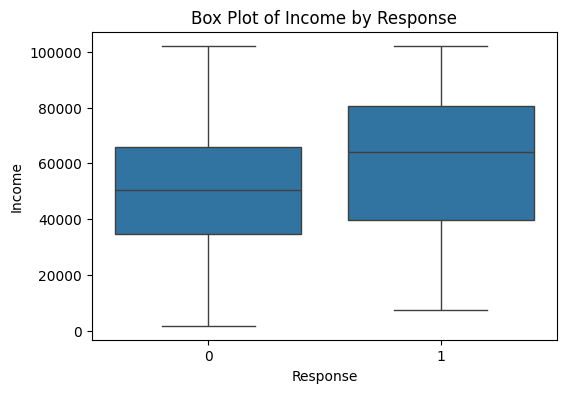

In [22]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df.Response, y=df.Income)
plt.xlabel('Response')
plt.ylabel('Income')
plt.title('Box Plot of Income by Response')
plt.show()

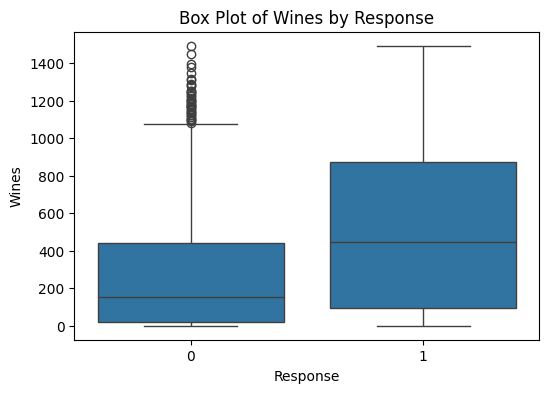

In [23]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df.Response, y=df.Wines)
plt.xlabel('Response')
plt.ylabel('Wines')
plt.title('Box Plot of Wines by Response')
plt.show()

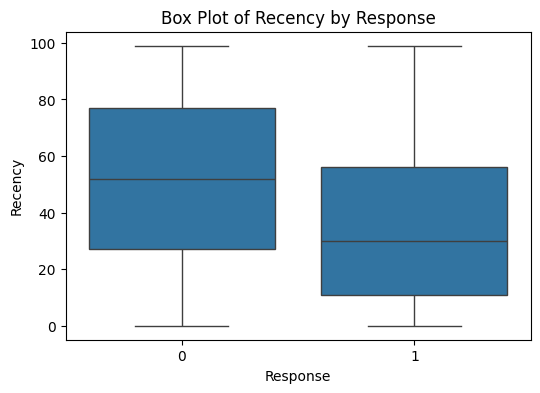

In [24]:
plt.figure(figsize = (6, 4))
sns.boxplot(x=df.Response, y=df.Recency)
plt.xlabel('Response')
plt.ylabel('Recency')
plt.title('Box Plot of Recency by Response')
plt.show()

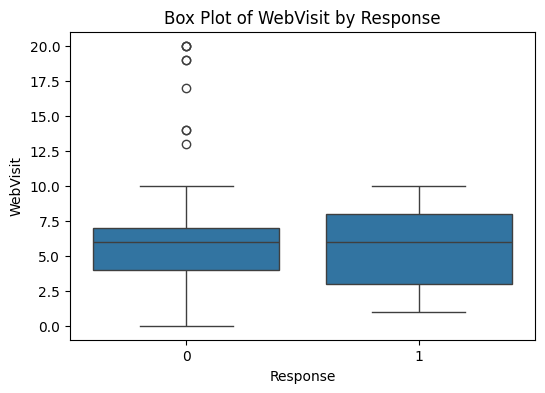

In [25]:
plt.figure(figsize = (6, 4))
sns.boxplot(x=df.Response, y=df.WebVisit)
plt.xlabel('Response')
plt.ylabel('WebVisit')
plt.title('Box Plot of WebVisit by Response')
plt.show()

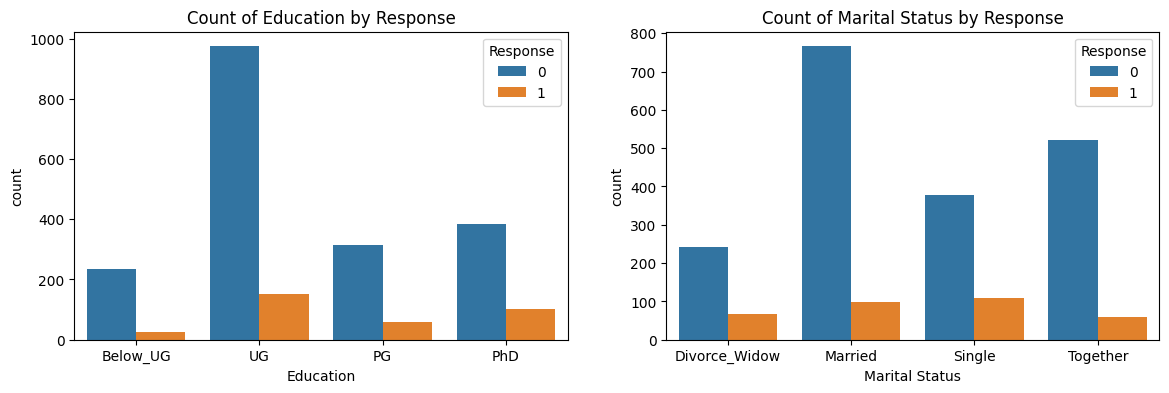

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.countplot(x=df.Education, hue=df.Response, ax=axes[0])
axes[0].set_title('Count of Education by Response')
sns.countplot(x=df.Status, hue=df.Response, ax=axes[1])
axes[1].set_title('Count of Marital Status by Response')
axes[1].set_xlabel('Marital Status')
plt.show()

### Multivariate Analysis

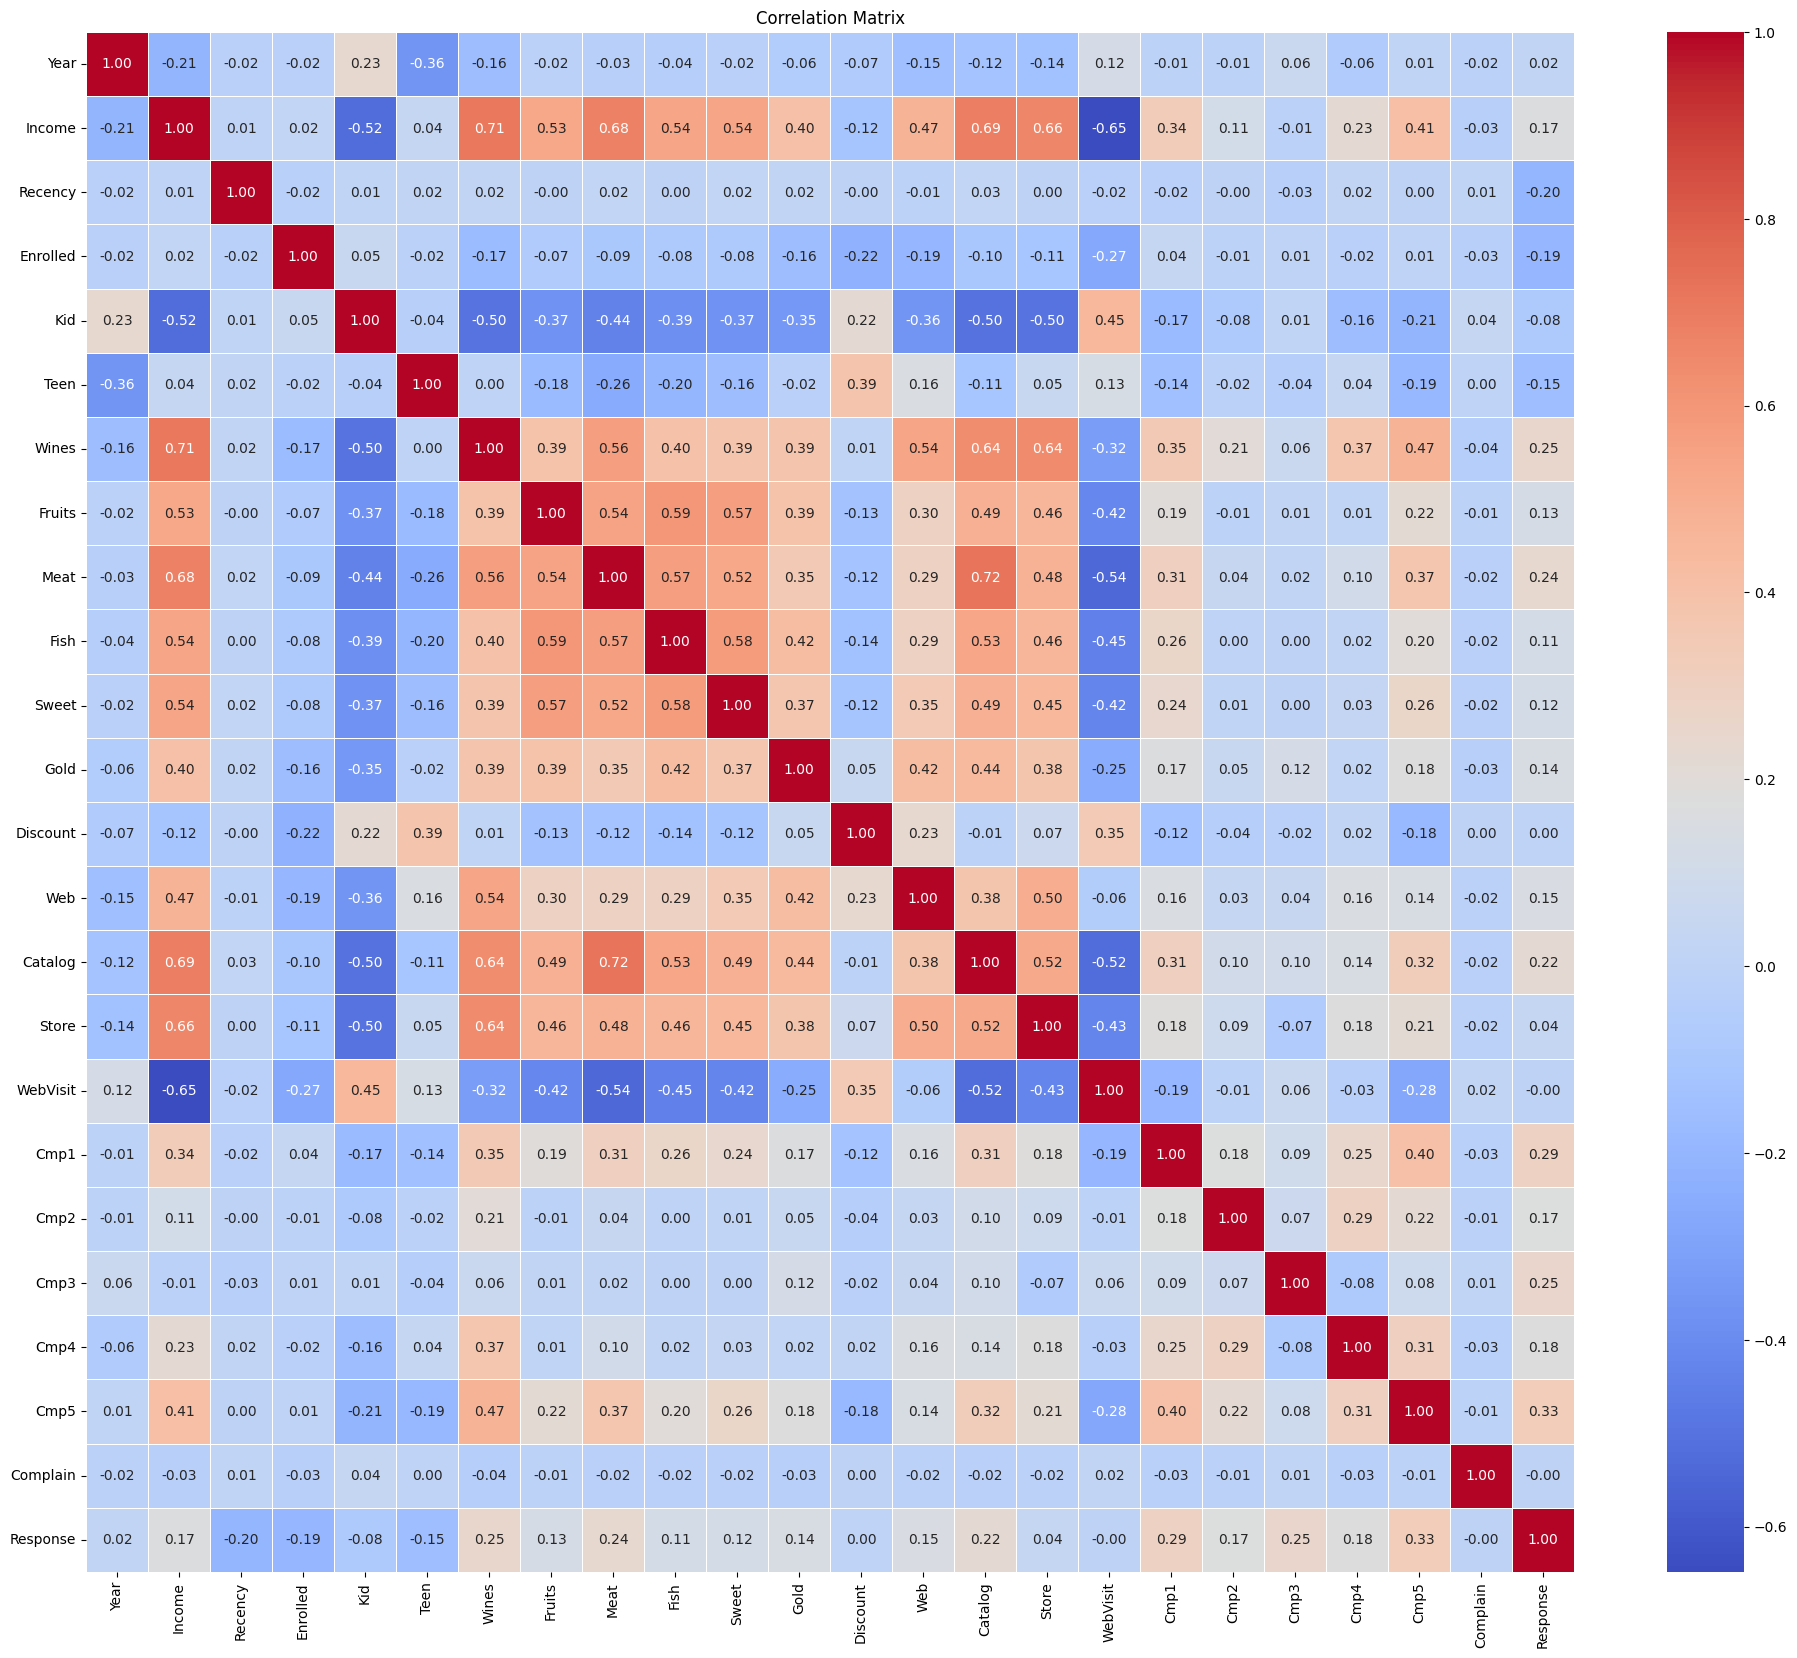

In [27]:
col = ['Year', 'Income', 'Recency',  'Enrolled', 'Kid', 'Teen', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold',
       'Discount', 'Web', 'Catalog', 'Store', 'WebVisit', 'Cmp1', 'Cmp2', 'Cmp3', 'Cmp4', 'Cmp5', 'Complain', 'Response']
plt.figure(figsize=(24, 20))
sns.heatmap(df[col].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Feature Engineering

In [28]:
New_df = df[['Education', 'Status', 'Income', 'Response']]

In [29]:
New_df['Loy_month'] = (datetime.now().year - df['Enrolled'].dt.year) * 12 + (datetime.now().month - df['Enrolled'].dt.month)
New_df['Is_recency'] = np.where(df['Recency'] < 32, 1, 0)
New_df['Tot_child'] = df[['Teen', 'Kid']].sum(axis=1)
New_df['Is_parent'] = np.where((df['Teen'] > 0) | (df['Kid'] > 0), 1, 0)
New_df['Inc_house'] = df['Income'] / (New_df['Tot_child'] + 2)
New_df['Tot_exp'] = df[['Wines',	'Fruits', 'Meat',	'Fish',	'Sweet', 'Gold']].sum(axis=1)
New_df['Exp_wine_per'] = (df['Wines'] / New_df['Tot_exp'])*100
New_df['Inc_exp_per'] = (New_df['Tot_exp'] / df['Income'])*100
New_df['Tot_pur'] = df[['Web',	'Catalog']].sum(axis=1)
New_df['Is_cmp_acc'] = np.where((df['Cmp1']>0)|(df['Cmp2']>0)|(df['Cmp3']>0)|(df['Cmp4']>0)|(df['Cmp5']>0), 1, 0)
New_df['Tot_cmp'] = df[['Cmp1','Cmp2','Cmp3','Cmp4','Cmp5']].sum(axis=1)

In [30]:
New_df = New_df[['Education', 'Status', 'Loy_month', 'Is_recency','Tot_child', 'Is_parent', 'Income', 'Inc_house', 'Tot_exp', 'Exp_wine_per', 
                 'Inc_exp_per', 'Tot_pur', 'Is_cmp_acc', 'Tot_cmp', 'Response']]

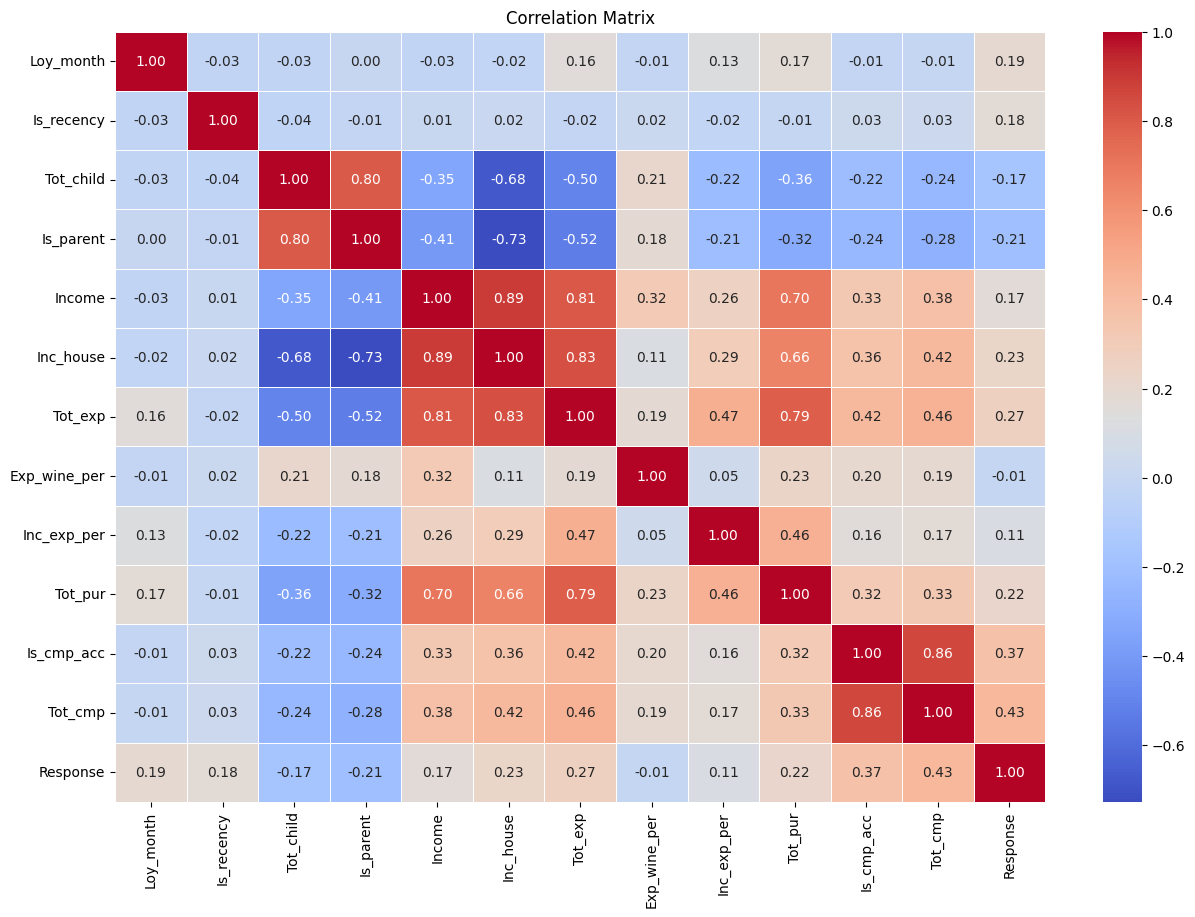

In [31]:
mat = New_df.drop(columns=['Education', 'Status'])
plt.figure(figsize = (15, 10))
sns.heatmap(mat.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [32]:
X = New_df.drop(columns = ['Education', 'Status', 'Response', 'Income', 'Loy_month'])
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

        feature        VIF
0    Is_recency   1.481520
1     Tot_child   7.681212
2     Is_parent   9.286871
3     Inc_house   9.376406
4       Tot_exp  10.200810
5  Exp_wine_per   6.592302
6   Inc_exp_per   1.846032
7       Tot_pur   8.836310
8    Is_cmp_acc   4.900691
9       Tot_cmp   4.866289


## Predictive Models

### Splitting Dataset (Training and Test Set), Label Encoding, Class-Imbalancing

In [33]:
X = df.drop(columns=['ID', 'Enrolled', 'Z_CostContact', 'Z_Revenue', 'Response'], axis=1)
y = df['Response']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=1)


X = New_df.drop(columns=['Response'], axis=1)
y = New_df['Response']

le = LabelEncoder()
X['Education'] = le.fit_transform(X['Education'])
X['Status'] = le.fit_transform(X['Status'])

smt = SMOTETomek(random_state=2)
X, y = smt.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

## Logistic Regression

### Dataset without Feature Engineering, Scaling and handling Class-Imbalance

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Year', 'Income', 'Kid', 'Teen', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet',
       'Gold', 'Discount', 'Web', 'Catalog', 'Store', 'WebVisit']),  # Scaling continuous variables
        ('cat', OneHotEncoder(), ['Education', 'Status']),  # One-hot encoding for categorical variable
        ('bin', 'passthrough', ['Cmp3', 'Cmp4', 'Cmp5', 'Cmp1', 'Cmp2', 'Complain'])  # Binary features left as is
    ])

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Train the model
pipeline.fit(X_train_1, y_train_1)

# Predict on the test and train set
y_test_pred = pipeline.predict(X_test_1)
y_train_pred = pipeline.predict(X_train_1)
train_accuracy = accuracy_score(y_train_1, y_train_pred)
test_accuracy = accuracy_score(y_test_1, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test_1, y_test_pred))

Training Accuracy: 0.86
Test Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       380
           1       0.44      0.12      0.19        68

    accuracy                           0.84       448
   macro avg       0.65      0.55      0.55       448
weighted avg       0.80      0.84      0.80       448



### Dataset with Feature Engineering, Scaling, and handling Class-Imbalance

Training Accuracy: 0.81
Test Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       337
           1       0.82      0.82      0.82       354

    accuracy                           0.82       691
   macro avg       0.82      0.82      0.82       691
weighted avg       0.82      0.82      0.82       691

[[273  64]
 [ 63 291]]


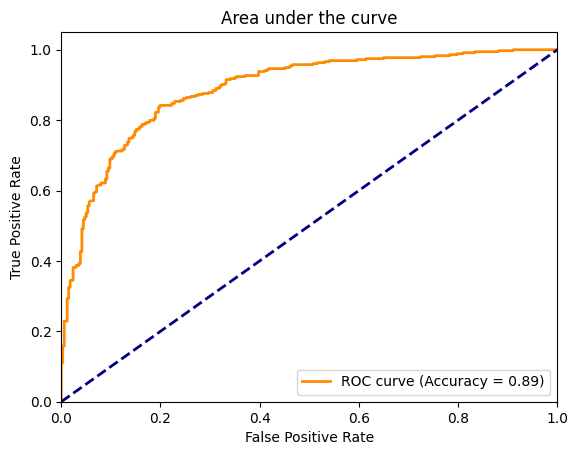

Cross-Validation Scores: [0.80831826 0.82097649 0.81012658 0.79891304 0.78623188]
Mean Cross-Validation Score: 0.80
Training Accuracy: 0.81


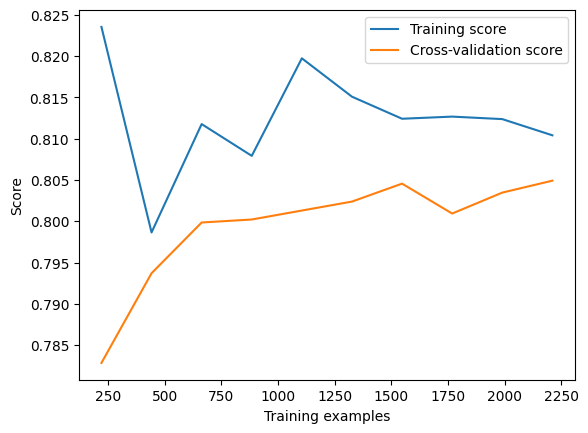

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Loy_month', 'Tot_child', 'Income', 'Inc_house', 'Tot_exp', 'Exp_wine_per', 'Inc_exp_per', 'Tot_pur',
                                  'Tot_cmp']),  # Scaling continuous variables
        ('cat', OneHotEncoder(), ['Education', 'Status']),  # One-hot encoding for categorical variable
        ('bin', 'passthrough', ['Is_recency', 'Is_parent', 'Is_cmp_acc'])  # Binary features left as is
    ])

# Create a pipeline with preprocessing, and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', C=1.0))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_test_pred))


# ROC Curve plot
y_test_prob = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Accuracy = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the curve')
plt.legend(loc='lower right')
plt.show()

# Cross-Validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.2f}")
print(f"Training Accuracy: {train_accuracy:.2f}")

train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

## Decision Tree Classifier

### Dataset without Feature Engineering, Scaling, and handling Class-Imbalance

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Year', 'Income', 'Kid', 'Teen', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet',
       'Gold', 'Discount', 'Web', 'Catalog', 'Store', 'WebVisit']),  # Scaling continuous variables
        ('cat', OneHotEncoder(), ['Education', 'Status']),  # One-hot encoding for categorical variable
        ('bin', 'passthrough', ['Cmp3', 'Cmp4', 'Cmp5', 'Cmp1', 'Cmp2', 'Complain'])  # Binary features left as is
    ])

# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=4))
])

# Train the model
pipeline.fit(X_train_1, y_train_1)

# Predict on the test set
y_test_pred = pipeline.predict(X_test_1)
y_train_pred = pipeline.predict(X_train_1)
train_accuracy = accuracy_score(y_train_1, y_train_pred)
test_accuracy = accuracy_score(y_test_1, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test_1, y_test_pred))

Training Accuracy: 0.99
Test Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       380
           1       0.44      0.47      0.46        68

    accuracy                           0.83       448
   macro avg       0.67      0.68      0.68       448
weighted avg       0.83      0.83      0.83       448



### Dataset with Feature Engineering, Scaling, and handling Class-Imbalance

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters found:
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
Test set accuracy with best parameters: 0.8263386396526773
Training Accuracy: 0.98
Test Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       337
           1       0.84      0.82      0.83       354

    accuracy                           0.83       691
   macro avg       0.83      0.83      0.83       691
weighted avg       0.83      0.83      0.83       691

[[282  55]
 [ 65 289]]


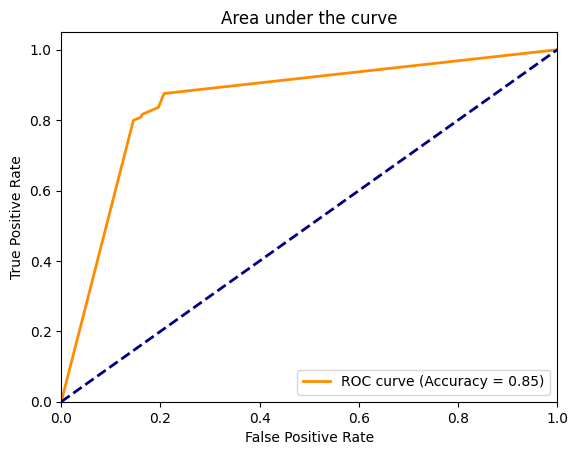

Cross-Validation Scores: [0.84810127 0.80650995 0.86980108 0.84601449 0.82427536]
Mean Cross-Validation Score: 0.84
Training Accuracy: 0.98


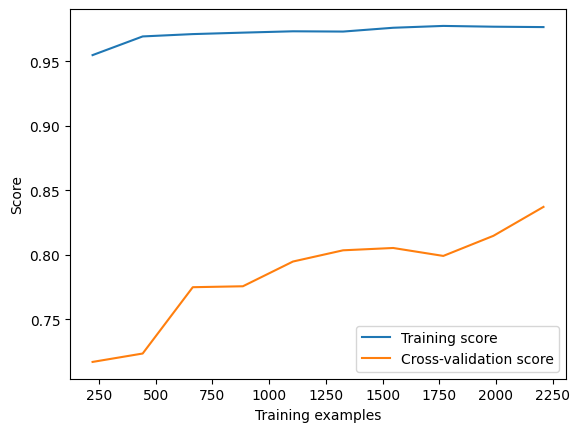

In [41]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Loy_month', 'Tot_child', 'Income', 'Inc_house', 'Tot_exp', 'Exp_wine_per', 'Inc_exp_per', 'Tot_pur',
                                  'Tot_cmp']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Education', 'Status']),
        ('bin', 'passthrough', ['Is_recency', 'Is_parent', 'Is_cmp_acc'])
    ])

# Preprocessing and resampling pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=5))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 3, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 5, 10],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and model performance
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test set accuracy with best parameters: {accuracy}')

# Predict on the test set
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_test_pred))


# ROC Curve plot
y_test_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Accuracy = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the curve')
plt.legend(loc='lower right')
plt.show()

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.2f}")
print(f"Training Accuracy: {train_accuracy:.2f}")

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

## Random Forest

### Dataset without Feature Engineering, Scaling, and handling Class-Imbalance

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Year', 'Income', 'Kid', 'Teen', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet',
       'Gold', 'Discount', 'Web', 'Catalog', 'Store', 'WebVisit']),  # Scaling continuous variables
        ('cat', OneHotEncoder(), ['Education', 'Status']),  # One-hot encoding for categorical variable
        ('bin', 'passthrough', ['Cmp3', 'Cmp4', 'Cmp5', 'Cmp1', 'Cmp2', 'Complain'])  # Binary features left as is
    ])

# Create a pipeline with preprocessing, and the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=6))
])

# Train the model
pipeline.fit(X_train_1, y_train_1)

# Predict on the test set
y_test_pred = pipeline.predict(X_test_1)
y_train_pred = pipeline.predict(X_train_1)
train_accuracy = accuracy_score(y_train_1, y_train_pred)
test_accuracy = accuracy_score(y_test_1, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test_1, y_test_pred))

Training Accuracy: 0.99
Test Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       380
           1       0.71      0.37      0.49        68

    accuracy                           0.88       448
   macro avg       0.81      0.67      0.71       448
weighted avg       0.87      0.88      0.87       448



### Dataset with Feature Engineering, Scaling, and handling Class-Imbalance

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Loy_month', 'Tot_child', 'Income', 'Inc_house', 'Tot_exp', 'Exp_wine_per', 'Inc_exp_per', 'Tot_pur',
                                  'Tot_cmp']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Education', 'Status']),
        ('bin', 'passthrough', ['Is_recency', 'Is_parent', 'Is_cmp_acc'])
    ])

# Preprocessing and resampling pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=7))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 15],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and model performance
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy with best parameters: {accuracy}')

# Predict on the test set
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_test_pred))


# ROC Curve plot
y_test_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Accuracy = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the curve')
plt.legend(loc='lower right')
plt.show()

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.2f}")
print(f"Training Accuracy: {train_accuracy:.2f}")

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


### Support Vector Machine

### Dataset without Feature Engineering, Scaling, and handling Class-Imbalance

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Year', 'Income', 'Kid', 'Teen', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet',
       'Gold', 'Discount', 'Web', 'Catalog', 'Store', 'WebVisit']),  # Scaling continuous variables
        ('cat', OneHotEncoder(), ['Education', 'Status']),  # One-hot encoding for categorical variable
        ('bin', 'passthrough', ['Cmp3', 'Cmp4', 'Cmp5', 'Cmp1', 'Cmp2', 'Complain'])  # Binary features left as is
    ])

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# Train the model
pipeline.fit(X_train_1, y_train_1)

# Predict on the test set
y_test_pred = pipeline.predict(X_test_1)
y_train_pred = pipeline.predict(X_train_1)
train_accuracy = accuracy_score(y_train_1, y_train_pred)
test_accuracy = accuracy_score(y_test_1, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test_1, y_test_pred))

Training Accuracy: 0.85
Test Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       380
           1       0.00      0.00      0.00        68

    accuracy                           0.85       448
   macro avg       0.42      0.50      0.46       448
weighted avg       0.72      0.85      0.78       448



### Dataset with Feature Engineering, Scaling, and handling Class-Imbalance

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Loy_month', 'Tot_child', 'Income', 'Inc_house', 'Tot_exp', 'Exp_wine_per', 'Inc_exp_per', 'Tot_pur',
                                  'Tot_cmp']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Education', 'Status']),
        ('bin', 'passthrough', ['Is_recency', 'Is_parent', 'Is_cmp_acc'])
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [1, 0.1, 0.01, 0.001],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and model evaluation
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy with best parameters: {accuracy}')

# Evaluate the model
print(f"Training Accuracy: {accuracy_score(y_train, best_model.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# ROC Curve plot
y_test_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.2f}")

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title('Learning Curve')
plt.grid(True)
plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

## K-Nearest Neighbour

### Dataset without Feature Engineering, Scaling, and handling Class-Imbalance

In [47]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Year', 'Income', 'Kid', 'Teen', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet',
       'Gold', 'Discount', 'Web', 'Catalog', 'Store', 'WebVisit']),  # Scaling continuous variables
        ('cat', OneHotEncoder(), ['Education', 'Status']),  # One-hot encoding for categorical variable
        ('bin', 'passthrough', ['Cmp3', 'Cmp4', 'Cmp5', 'Cmp1', 'Cmp2', 'Complain'])  # Binary features left as is
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Train the model
pipeline.fit(X_train_1, y_train_1)

# Predict on the test set
y_test_pred = pipeline.predict(X_test_1)
y_train_pred = pipeline.predict(X_train_1)
train_accuracy = accuracy_score(y_train_1, y_train_pred)
test_accuracy = accuracy_score(y_test_1, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test_1, y_test_pred))

Training Accuracy: 0.88
Test Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.85      0.94      0.90       380
           1       0.25      0.10      0.15        68

    accuracy                           0.82       448
   macro avg       0.55      0.52      0.52       448
weighted avg       0.76      0.82      0.78       448



### Dataset with Feature Engineering, Scaling, and handling Class-Imbalance

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found:
{'classifier__algorithm': 'auto', 'classifier__n_neighbors': 1, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Test set accuracy with best parameters: 0.86
Training Accuracy: 0.99
Test Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.89      0.80      0.85       337
           1       0.83      0.91      0.87       354

    accuracy                           0.86       691
   macro avg       0.86      0.86      0.86       691
weighted avg       0.86      0.86      0.86       691

[[270  67]
 [ 32 322]]


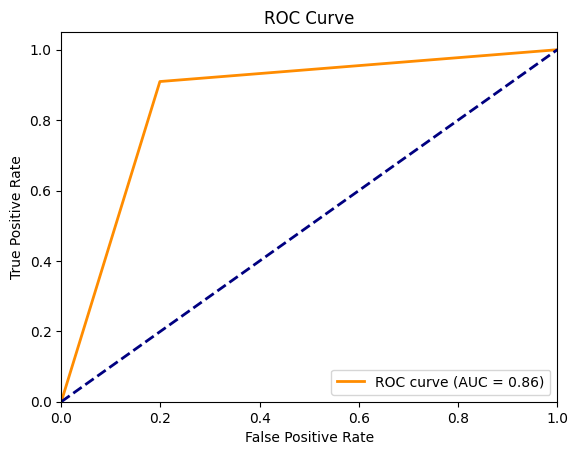

Cross-Validation Scores: [0.87703436 0.84810127 0.86256781 0.86413043 0.85688406]
Mean Cross-Validation Score: 0.86


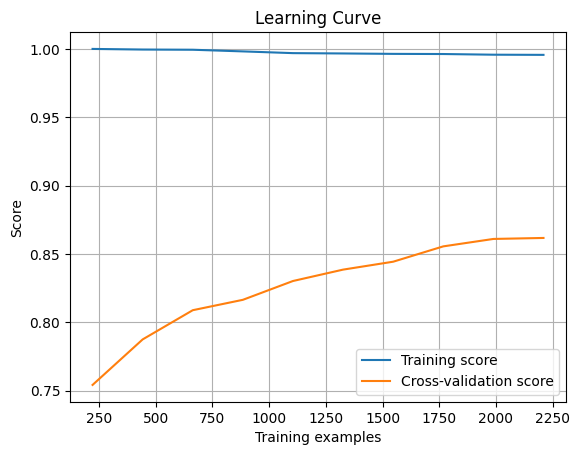

In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Loy_month', 'Tot_child', 'Income', 'Inc_house', 'Tot_exp', 'Exp_wine_per', 'Inc_exp_per', 'Tot_pur',
                                  'Tot_cmp']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Education', 'Status']),
        ('bin', 'passthrough', ['Is_recency', 'Is_parent', 'Is_cmp_acc'])
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': [1, 3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__p': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and model performance
print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy with best parameters: {accuracy:.2f}')

# Evaluate the model
print(f"Training Accuracy: {accuracy_score(y_train, best_model.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# ROC Curve plot
y_test_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.2f}")

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title('Learning Curve')
plt.grid(True)
plt.show()

## Naive Bayes

### Dataset without Feature Engineering, Scaling, and handling Class-Imbalance

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Year', 'Income', 'Kid', 'Teen', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet',
       'Gold', 'Discount', 'Web', 'Catalog', 'Store', 'WebVisit']),  # Scaling continuous variables
        ('cat', OneHotEncoder(), ['Education', 'Status']),  # One-hot encoding for categorical variable
        ('bin', 'passthrough', ['Cmp3', 'Cmp4', 'Cmp5', 'Cmp1', 'Cmp2', 'Complain'])  # Binary features left as is
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Train the model
pipeline.fit(X_train_1, y_train_1)

# Predict on the test set
y_test_pred = pipeline.predict(X_test_1)
y_train_pred = pipeline.predict(X_train_1)
train_accuracy = accuracy_score(y_train_1, y_train_pred)
test_accuracy = accuracy_score(y_test_1, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test_1, y_test_pred))

Training Accuracy: 0.78
Test Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       380
           1       0.33      0.47      0.39        68

    accuracy                           0.77       448
   macro avg       0.61      0.65      0.62       448
weighted avg       0.81      0.77      0.79       448



### Dataset with Feature Engineering, Scaling, handled Class-Imbalance, and Hyper Tuning

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'classifier__var_smoothing': 0.0004328761281083057}
Test set accuracy with best parameters: 0.7467438494934877
Training Accuracy: 0.73
Test Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       337
           1       0.78      0.71      0.74       354

    accuracy                           0.75       691
   macro avg       0.75      0.75      0.75       691
weighted avg       0.75      0.75      0.75       691

[[264  73]
 [102 252]]


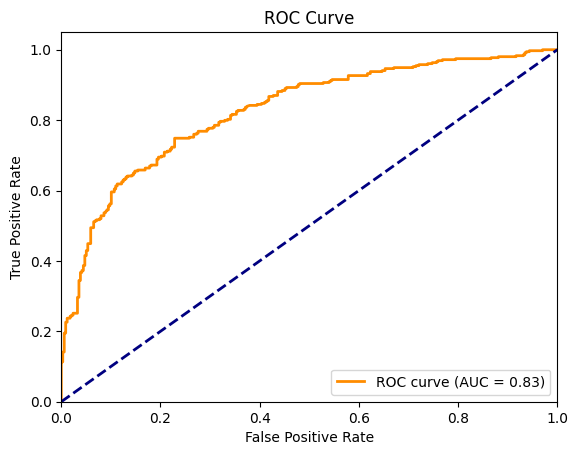

Cross-Validation Scores: [0.7034358  0.76491863 0.75406872 0.70108696 0.72101449]
Mean Cross-Validation Score: 0.73


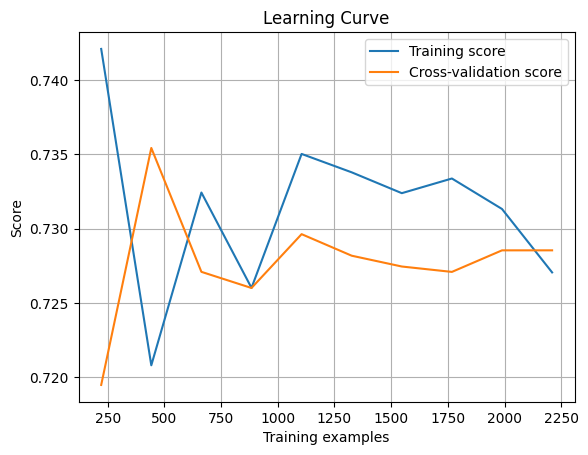

In [54]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Loy_month', 'Tot_child', 'Income', 'Inc_house', 'Tot_exp', 'Exp_wine_per', 'Inc_exp_per', 'Tot_pur', 'Tot_cmp']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Education', 'Status']),
        ('bin', 'passthrough', ['Is_recency', 'Is_parent', 'Is_cmp_acc'])
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

param_grid = {
    'classifier__var_smoothing': np.logspace(0, -9, num=100)
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and model evaluation
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy with best parameters: {accuracy}')

# Evaluate the model
print(f"Training Accuracy: {accuracy_score(y_train, best_model.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# ROC Curve plot
y_test_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.2f}")

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title('Learning Curve')
plt.grid(True)
plt.show()

## XGBoost

### Dataset without Feature Engineering, Scaling, handled Class-Imbalance, and Hyper Tuning

In [61]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Year', 'Income', 'Kid', 'Teen', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet',
       'Gold', 'Discount', 'Web', 'Catalog', 'Store', 'WebVisit']),  # Scaling continuous variables
        ('cat', OneHotEncoder(), ['Education', 'Status']),  # One-hot encoding for categorical variable
        ('bin', 'passthrough', ['Cmp3', 'Cmp4', 'Cmp5', 'Cmp1', 'Cmp2', 'Complain'])  # Binary features left as is
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False))
])

# Train the model
pipeline.fit(X_train_1, y_train_1)

# Predict on the test set
y_test_pred = pipeline.predict(X_test_1)
y_train_pred = pipeline.predict(X_train_1)
train_accuracy = accuracy_score(y_train_1, y_train_pred)
test_accuracy = accuracy_score(y_test_1, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test_1, y_test_pred))

Training Accuracy: 0.99
Test Accuracy: 0.86
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       380
           1       0.56      0.47      0.51        68

    accuracy                           0.86       448
   macro avg       0.73      0.70      0.72       448
weighted avg       0.86      0.86      0.86       448



### Dataset with Feature Engineering, Scaling, handled Class-Imbalance, and Hyper Tuning

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Test set accuracy with best parameters: 0.9001447178002895
Training Accuracy: 0.99
Test Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       337
           1       0.89      0.92      0.90       354

    accuracy                           0.90       691
   macro avg       0.90      0.90      0.90       691
weighted avg       0.90      0.90      0.90       691

[[298  39]
 [ 30 324]]


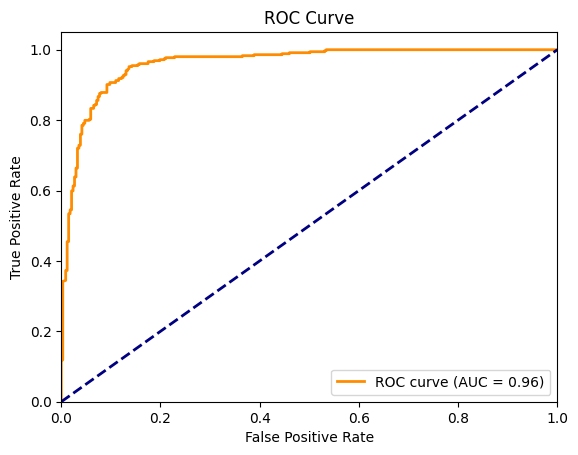

KeyboardInterrupt: 

In [57]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Loy_month', 'Tot_child', 'Income', 'Inc_house', 'Tot_exp', 'Exp_wine_per', 'Inc_exp_per', 'Tot_pur', 'Tot_cmp']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Education', 'Status']),
        ('bin', 'passthrough', ['Is_recency', 'Is_parent', 'Is_cmp_acc'])
    ])

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5],
    'classifier__colsample_bytree': [0.5, 0.7, 1.0],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and model evaluation
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy with best parameters: {accuracy}')

# Evaluate the model
print(f"Training Accuracy: {accuracy_score(y_train, best_model.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# ROC Curve plot
y_test_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.2f}")

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title('Learning Curve')
plt.grid(True)
plt.show()


## LightGBM

### Dataset without Feature Engineering, Scaling, handled Class-Imbalance, and Hyper Tuning

In [62]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['Year', 'Income', 'Kid', 'Teen', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet',
       'Gold', 'Discount', 'Web', 'Catalog', 'Store', 'WebVisit']),  # Scaling continuous variables
        ('cat', OneHotEncoder(), ['Education', 'Status']),  # One-hot encoding for categorical variable
        ('bin', 'passthrough', ['Cmp3', 'Cmp4', 'Cmp5', 'Cmp1', 'Cmp2', 'Complain'])  # Binary features left as is
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier())
])

# Train the model
pipeline.fit(X_train_1, y_train_1)

# Predict on the test set
y_test_pred = pipeline.predict(X_test_1)
y_train_pred = pipeline.predict(X_train_1)
train_accuracy = accuracy_score(y_train_1, y_train_pred)
test_accuracy = accuracy_score(y_test_1, y_test_pred)

# Evaluate the model
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(classification_report(y_test_1, y_test_pred))

[LightGBM] [Info] Number of positive: 266, number of negative: 1526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148438 -> initscore=-1.746909
[LightGBM] [Info] Start training from score -1.746909
Training Accuracy: 0.99
Test Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       380
           1       0.62      0.49      0.55        68

    accuracy                           0.88       448
   macro avg       0.77      0.72      0.74       448
weighted avg       0.87      0.88      0.87       448



### Dataset with Feature Engineering, Scaling, handled Class-Imbalance, and Hyper Tuning

In [60]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Loy_month', 'Tot_child', 'Income', 'Inc_house', 'Tot_exp', 'Exp_wine_per', 'Inc_exp_per', 'Tot_pur', 'Tot_cmp']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Education', 'Status']),
        ('bin', 'passthrough', ['Is_recency', 'Is_parent', 'Is_cmp_acc'])
    ])

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier())
])

# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__num_leaves': [31, 50],
    'classifier__boosting_type': ['gbdt', 'dart'],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__subsample': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and model evaluation
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy with best parameters: {accuracy}')

# Evaluate the model
print(f"Training Accuracy: {accuracy_score(y_train, best_model.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# ROC Curve plot
y_test_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.2f}")

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title('Learning Curve')
plt.grid(True)
plt.show()

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 